# ML Reglas de Precio

Objetivo: Identificar factores determinantes para clasificación de reglas de precio e incremento de Ingresos (Estimated Revenue)

Variables disponibles cualitativas:
    - Mes
    - Sitio (DFP Ad Unit)
    - Dispositivo (Device category)
    - Tipo de transacción (Transaction Type)
    - Tamaño de creativo (Creative Size)

Variables disponibles cuantitativas:
    - Ad Requests.
    - Matched Requests.
    - Clicks.
    - Estimated Revenue
    - Ad Impressions
    - Active View Enabled Impressions
    - Active View measured Impressions
    
$$eCPM = \frac{Ingresos}{Impresiones Vendidas} * 1000$$  
$$Fill Rate = \frac{Impresiones Vendidas}{Oportunidades}$$  
$$rCPM = \frac{Ingresos}{Oportunidades} * 1000 = eCPM * Fill Rate$$  
$$Viewability = \frac{Impresiones Vistas}{Impresiones Disponibles} * 1000$$

Actualmente tenemos los siguientes RMSE:  
LinearRegressor: 4.163198550626033  
Árbol de Decisión con CV: 2.0217106846949955  
LinearRegressor con CV: 4.144651321967734  
SVM: 4.541685841508111  
Random Forest Grid : 2.94553254567179 {max_features': 8, 'n_estimators': 30}  
Random Forest RandomizedSearchCV: 2.9591995838687026 {'max_features': 7, 'n_estimators': 122}

In [71]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [72]:
# Carga de archivo base de datos.
import os
import tarfile
import urllib.request
import pandas as pd

HOUSING_PATH = os.path.join("datasets")

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "newbase_pricing_rules_open.csv")
    return pd.read_csv(csv_path)

# Carga y primera visualización de datos

In [73]:
# Visualización de la carga
housing = load_housing_data()
housing.head()

,Months,Sitio,Position Ad Unit,Device,Region,Ad requests,Matched requests,Clicks,Estimated revenue (MX$),Ad impressions,Active view enabled impressions,Active view measured impressions
0,01/08/2020,Actitudfem,1x1,Desktop,Latinoamerica,27479,29,0,0.11,21,21,21
1,01/08/2020,Actitudfem,1x1,Desktop,Mexico,38906,401,0,2.07,378,378,378
2,01/08/2020,Actitudfem,1x1,Desktop,United States,248,0,0,0.00,0,0,0
3,01/08/2020,Actitudfem,1x1,Mobile,Latinoamerica,119110,682,0,0.59,556,556,548
4,01/08/2020,Actitudfem,1x1,Mobile,Mexico,327530,332,0,0.43,269,269,265


In [74]:
# Información de tipo de datos por cada campo
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9993 entries, 0 to 9992
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Months                            9993 non-null   object 
 1   Sitio                             9993 non-null   object 
 2   Position Ad Unit                  9993 non-null   object 
 3   Device                            9993 non-null   object 
 4   Region                            9993 non-null   object 
 5   Ad requests                       9993 non-null   int64  
 6   Matched requests                  9993 non-null   int64  
 7   Clicks                            9993 non-null   int64  
 8   Estimated revenue (MX$)           9993 non-null   float64
 9   Ad impressions                    9993 non-null   int64  
 10  Active view enabled impressions   9993 non-null   int64  
 11  Active view measured impressions  9993 non-null   int64  
dtypes: flo

In [75]:
housing.describe()

,Ad requests,Matched requests,Clicks,Estimated revenue (MX$),Ad impressions,Active view enabled impressions,Active view measured impressions
count,9.993000e+03,9.993000e+03,9993.000000,9993.000000,9.993000e+03,9.993000e+03,9.993000e+03
mean,6.638333e+05,2.094491e+05,675.446312,1063.895090,1.729559e+05,1.726829e+05,1.722756e+05
std,2.748040e+06,1.153286e+06,5227.741275,5204.042945,9.640723e+05,9.633612e+05,9.614254e+05
min,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.249000e+03,6.800000e+01,0.000000,0.350000,5.300000e+01,5.200000e+01,5.200000e+01
50%,3.386600e+04,3.677000e+03,5.000000,19.870000,2.784000e+03,2.772000e+03,2.765000e+03
75%,2.607290e+05,4.820800e+04,84.000000,307.380000,3.712100e+04,3.711100e+04,3.710700e+04
max,7.495211e+07,3.980057e+07,171822.000000,128891.000000,3.636470e+07,3.636379e+07,3.629538e+07


Saving figure attribute_histogram_plots


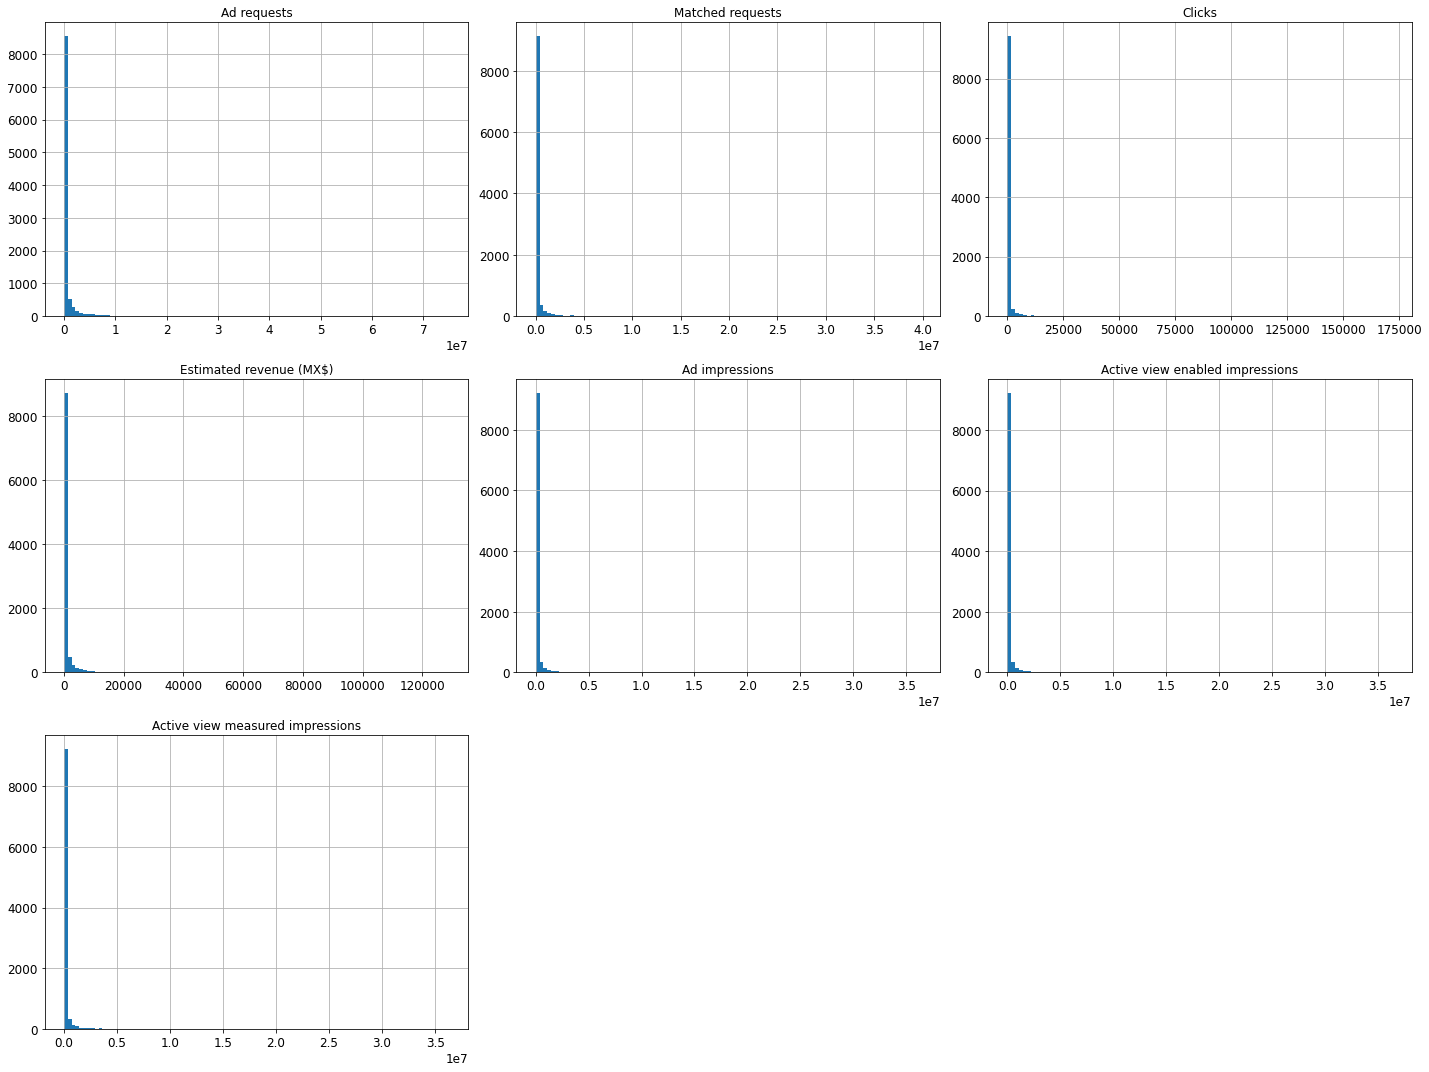

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=100, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

# Generación de set de entramiento 80% y validación 20%

In [77]:
# Creación de Métrica rCPM Ingresos/Ad Requests * 1,000
housing['rCPM'] = housing['Estimated revenue (MX$)']/housing['Ad requests']*1000

<AxesSubplot:>

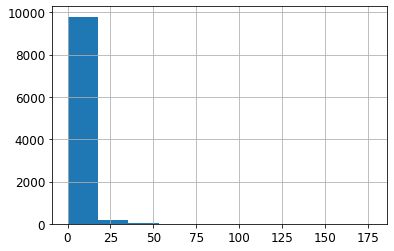

In [78]:
housing["rCPM"].hist()

In [79]:
housing['rCPM_cat'] = pd.cut(housing["rCPM"],
                               bins=[-np.inf, 1., 2., 3., 4., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [80]:
housing["rCPM_cat"].value_counts()

1    4789
5    2059
2    1589
3     952
4     604
Name: rCPM_cat, dtype: int64

<AxesSubplot:>

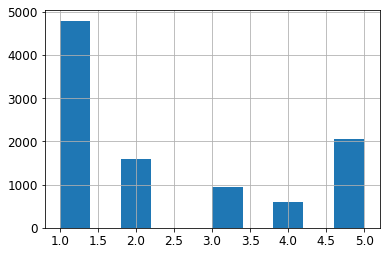

In [81]:
housing["rCPM_cat"].hist()

In [82]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["rCPM_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [83]:
strat_test_set["rCPM_cat"].value_counts() / len(strat_test_set)

1    0.479240
5    0.206103
2    0.159080
3    0.095048
4    0.060530
Name: rCPM_cat, dtype: float64

In [84]:
housing["rCPM_cat"].value_counts() / len(housing)

1    0.479235
5    0.206044
2    0.159011
3    0.095267
4    0.060442
Name: rCPM_cat, dtype: float64

In [85]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("rCPM_cat", axis=1, inplace=True)

# Visualizar (dispersiones) y explorar (correlaciones, histogramas, etc.)

In [86]:
housing = strat_train_set.copy()

Saving figure better_visualization_plot


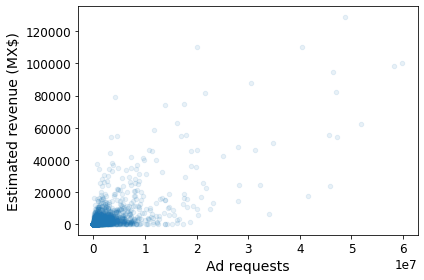

In [87]:
housing.plot(kind="scatter", x="Ad requests", y="Estimated revenue (MX$)", alpha=0.1)
save_fig("better_visualization_plot")

Saving figure scatter_matrix_plot


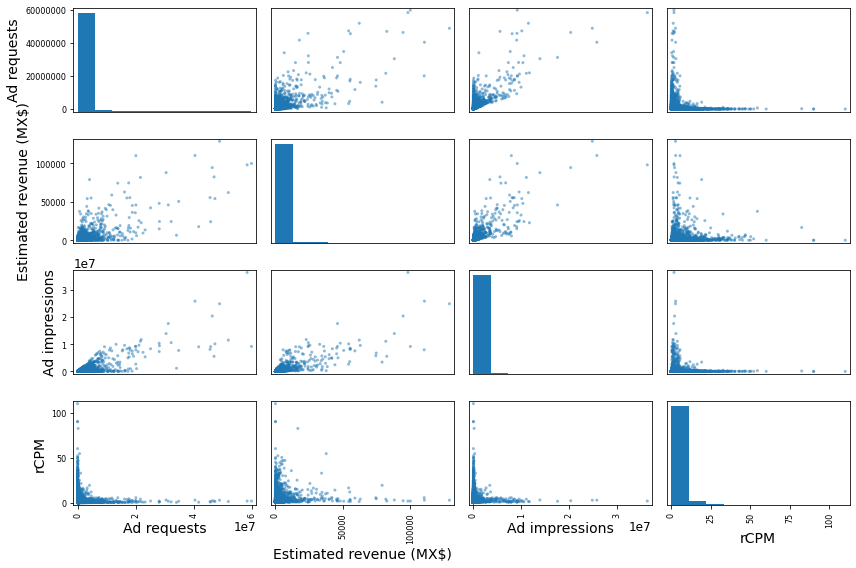

In [88]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

housing['rCPM'] = housing['Estimated revenue (MX$)']/housing['Ad requests']*1000

attributes = ["Ad requests", "Estimated revenue (MX$)", "Ad impressions",
              "rCPM"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure rCPM_vs_estimated_revenue


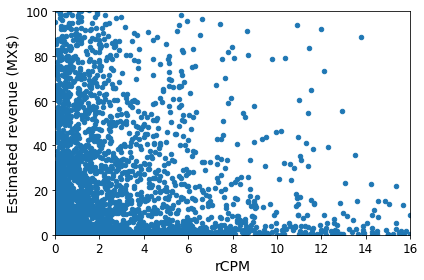

In [89]:
housing.plot(kind="scatter", x="rCPM", y="Estimated revenue (MX$)")
plt.axis([0, 16, 0, 100])
save_fig("rCPM_vs_estimated_revenue")

In [90]:
housing['Viewability'] = housing['Active view measured impressions']/housing['Active view enabled impressions']
housing['eCPM'] = housing['Estimated revenue (MX$)']/housing['Ad impressions']*1000
housing['Fill Rate'] = housing['Ad impressions']/housing['Ad requests']

In [91]:
corr_matrix = housing.corr()
corr_matrix["rCPM"].sort_values(ascending=False)

rCPM                                1.000000
eCPM                                0.540616
Fill Rate                           0.445384
Estimated revenue (MX$)             0.104671
Clicks                              0.018323
Viewability                         0.002804
Ad impressions                     -0.005518
Active view enabled impressions    -0.005543
Active view measured impressions   -0.005554
Matched requests                   -0.007657
Ad requests                        -0.058528
Name: rCPM, dtype: float64

In [92]:
corr_matrix = housing.corr()
corr_matrix["Estimated revenue (MX$)"].sort_values(ascending=False)

Estimated revenue (MX$)             1.000000
Matched requests                    0.849770
Clicks                              0.833102
Ad impressions                      0.819791
Active view enabled impressions     0.819547
Active view measured impressions    0.819266
Ad requests                         0.733124
Fill Rate                           0.112700
rCPM                                0.104671
eCPM                                0.030588
Viewability                         0.017526
Name: Estimated revenue (MX$), dtype: float64

# Preparar (limpieza de datos, escalamiento)

In [93]:
housing = strat_train_set.drop("rCPM", axis=1) # drop labels for training set
housing_labels = strat_train_set["rCPM"].copy()

In [94]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

In [95]:

housing_num = housing.drop('Months', axis=1)
housing_num = housing_num.drop('Sitio', axis=1)
housing_num = housing_num.drop('Position Ad Unit', axis=1)
housing_num = housing_num.drop('Device', axis=1)
housing_num = housing_num.drop('Region', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [96]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [97]:
imputer.statistics_

array([3.51005e+04, 3.73150e+03, 5.00000e+00, 2.03400e+01, 2.87300e+03,
       2.87200e+03, 2.85600e+03])

In [98]:
X = imputer.transform(housing_num)

In [99]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)
housing_tr.head()

,Ad requests,Matched requests,Clicks,Estimated revenue (MX$),Ad impressions,Active view enabled impressions,Active view measured impressions
9926,223089.0,205097.0,359.0,479.37,124782.0,124450.0,123897.0
2761,369.0,124.0,0.0,0.92,113.0,113.0,113.0
8957,3195.0,1773.0,5.0,39.26,1617.0,1603.0,1601.0
6091,68986.0,2144.0,20.0,29.34,2016.0,2016.0,1887.0
9475,161.0,97.0,0.0,0.61,71.0,71.0,68.0


In [100]:
housing_cat = housing[['Months']]
housing_cat['Sitio'] = housing[['Sitio']]
housing_cat['Position Ad Unit'] = housing[['Position Ad Unit']]
housing_cat['Device'] = housing[['Device']]
housing_cat['Region'] = housing[['Region']]
housing_cat.head(10)

C:\Users\Aaron\AppData\Local\Temp\ipykernel_17656\708771082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_cat['Sitio'] = housing[['Sitio']]
C:\Users\Aaron\AppData\Local\Temp\ipykernel_17656\708771082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_cat['Position Ad Unit'] = housing[['Position Ad Unit']]
C:\Users\Aaron\AppData\Local\Temp\ipykernel_17656\708771082.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

,Months,Sitio,Position Ad Unit,Device,Region
9926,01/08/2022,Me_lo_dijo_Lola,Zocalo,Mobile,Mexico
2761,01/02/2021,Me_lo_dijo_Lola,728x90,Desktop,United States
8957,01/06/2022,Cocina_Delirante,728x90,Desktop,United States
6091,01/11/2021,Actitudfem,box_multi,Mobile,Mexico
9475,01/07/2022,Imagen,300x100,Mobile,United States
25,01/08/2020,Actitudfem,box_multi,Desktop,Latinoamerica
5012,01/08/2021,DineroenImagen,1x1,Desktop,Mexico
1803,01/12/2020,DineroenImagen,728x90,Desktop,Latinoamerica
2639,01/02/2021,DineroenImagen,Zocalo,Mobile,United States
7796,01/03/2022,DineroenImagen,300x250,Mobile,Mexico


In [101]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

In [102]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[16.,  8., 15.,  1.,  1.],
       [ 2.,  8., 10.,  0.,  2.],
       [11.,  3., 10.,  0.,  2.],
       [22.,  0., 18.,  1.,  1.],
       [13.,  6.,  3.,  1.,  2.],
       [14.,  0., 18.,  0.,  0.],
       [15.,  4.,  2.,  0.,  1.],
       [23.,  4., 10.,  0.,  0.],
       [ 2.,  4., 15.,  1.,  2.],
       [ 5.,  4.,  4.,  1.,  1.]])

In [103]:
ordinal_encoder.categories_

[array(['01/01/2021', '01/01/2022', '01/02/2021', '01/02/2022',
        '01/03/2021', '01/03/2022', '01/04/2021', '01/04/2022',
        '01/05/2021', '01/05/2022', '01/06/2021', '01/06/2022',
        '01/07/2021', '01/07/2022', '01/08/2020', '01/08/2021',
        '01/08/2022', '01/09/2020', '01/09/2021', '01/10/2020',
        '01/10/2021', '01/11/2020', '01/11/2021', '01/12/2020',
        '01/12/2021'], dtype=object),
 array(['Actitudfem', 'Adrenalina360', 'Atraccion360', 'Cocina_Delirante',
        'DineroenImagen', 'Excelsior', 'Imagen', 'ImagenTV',
        'Me_lo_dijo_Lola', 'Passbacks_Invent', 'RSVP', 'Salud180',
        'Testing_Invent', 'Youtube'], dtype=object),
 array(['160x600', '180_20', '1x1', '300x100', '300x250', '300x600',
        '320x100', '320x480', '320x50', '468x60', '728x90', 'Native',
        'Passbacks', 'Tags', 'Youtube', 'Zocalo', 'box_amp', 'box_galeria',
        'box_multi', 'contenido', 'gen_amp', 'wide'], dtype=object),
 array(['Desktop', 'Mobile'], dtype=ob

In [104]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<7994x66 sparse matrix of type '<class 'numpy.float64'>'
	with 39970 stored elements in Compressed Sparse Row format>

In [105]:
housing_cat_1hot.toarray()

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [106]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [107]:
cat_encoder.categories_

[array(['01/01/2021', '01/01/2022', '01/02/2021', '01/02/2022',
        '01/03/2021', '01/03/2022', '01/04/2021', '01/04/2022',
        '01/05/2021', '01/05/2022', '01/06/2021', '01/06/2022',
        '01/07/2021', '01/07/2022', '01/08/2020', '01/08/2021',
        '01/08/2022', '01/09/2020', '01/09/2021', '01/10/2020',
        '01/10/2021', '01/11/2020', '01/11/2021', '01/12/2020',
        '01/12/2021'], dtype=object),
 array(['Actitudfem', 'Adrenalina360', 'Atraccion360', 'Cocina_Delirante',
        'DineroenImagen', 'Excelsior', 'Imagen', 'ImagenTV',
        'Me_lo_dijo_Lola', 'Passbacks_Invent', 'RSVP', 'Salud180',
        'Testing_Invent', 'Youtube'], dtype=object),
 array(['160x600', '180_20', '1x1', '300x100', '300x250', '300x600',
        '320x100', '320x480', '320x50', '468x60', '728x90', 'Native',
        'Passbacks', 'Tags', 'Youtube', 'Zocalo', 'box_amp', 'box_galeria',
        'box_multi', 'contenido', 'gen_amp', 'wide'], dtype=object),
 array(['Desktop', 'Mobile'], dtype=ob

In [108]:
housing.columns

Index(['Months', 'Sitio', 'Position Ad Unit', 'Device', 'Region',
       'Ad requests', 'Matched requests', 'Clicks', 'Estimated revenue (MX$)',
       'Ad impressions', 'Active view enabled impressions',
       'Active view measured impressions'],
      dtype='object')

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [110]:
housing_num_tr

array([[-0.16813047, -0.00878913, -0.06516646, ..., -0.05372746,
        -0.05381319, -0.05405431],
       [-0.24868532, -0.18521427, -0.13537732, ..., -0.17819807,
        -0.1780441 , -0.17797427],
       [-0.2476632 , -0.18379494, -0.13439945, ..., -0.17669646,
        -0.17655537, -0.17648464],
       ...,
       [-0.23899574, -0.1731366 , -0.13205257, ..., -0.16476149,
        -0.16462756, -0.16453753],
       [-0.24881698, -0.18532014, -0.13537732, ..., -0.17831089,
        -0.178157  , -0.1780874 ],
       [ 0.75972893, -0.18527711, -0.13537732, ..., -0.17828493,
        -0.17813103, -0.17806137]])

In [111]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [138]:
num_attribs = list(housing_num)
cat_attribs = ['Months', 'Sitio', 'Position Ad Unit', 'Device', 'Region']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [145]:
type(housing_prepared)

scipy.sparse.csr.csr_matrix

In [115]:
housing_prepared.shape

(7994, 73)

In [116]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [130]:
num_attribs = list(housing_num)
cat_attribs = ["Months", 'Sitio', 'Position Ad Unit', 'Device', 'Region']

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [131]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [125]:
housing.head()

,Months,Sitio,Position Ad Unit,Device,Region,Ad requests,Matched requests,Clicks,Estimated revenue (MX$),Ad impressions,Active view enabled impressions,Active view measured impressions
9926,01/08/2022,Me_lo_dijo_Lola,Zocalo,Mobile,Mexico,223089,205097,359,479.37,124782,124450,123897
2761,01/02/2021,Me_lo_dijo_Lola,728x90,Desktop,United States,369,124,0,0.92,113,113,113
8957,01/06/2022,Cocina_Delirante,728x90,Desktop,United States,3195,1773,5,39.26,1617,1603,1601
6091,01/11/2021,Actitudfem,box_multi,Mobile,Mexico,68986,2144,20,29.34,2016,2016,1887
9475,01/07/2022,Imagen,300x100,Mobile,United States,161,97,0,0.61,71,71,68


In [132]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-0.16813047, -0.00878913, -0.06516646, ...,  0.        ,
         1.        ,  0.        ],
       [-0.24868532, -0.18521427, -0.13537732, ...,  0.        ,
         0.        ,  1.        ],
       [-0.2476632 , -0.18379494, -0.13439945, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.23899574, -0.1731366 , -0.13205257, ...,  1.        ,
         0.        ,  0.        ],
       [-0.24881698, -0.18532014, -0.13537732, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.75972893, -0.18527711, -0.13537732, ...,  1.        ,
         0.        ,  0.        ]])

In [146]:
old_housing_prepared

array([[-0.16813047, -0.00878913, -0.06516646, ...,  0.        ,
         1.        ,  0.        ],
       [-0.24868532, -0.18521427, -0.13537732, ...,  0.        ,
         0.        ,  1.        ],
       [-0.2476632 , -0.18379494, -0.13439945, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.23899574, -0.1731366 , -0.13205257, ...,  1.        ,
         0.        ,  0.        ],
       [-0.24881698, -0.18532014, -0.13537732, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.75972893, -0.18527711, -0.13537732, ...,  1.        ,
         0.        ,  0.        ]])

In [137]:
old_housing_prepared.shape

(7994, 73)

In [135]:
# Esto hace comparación de la manera manual y al llevarlo a un pipeline, el cual no nos deja comparar por formato de arreglos.
np.allclose(housing_prepared, old_housing_prepared)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# Select and train model

In [182]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) #Aquí ocupé old_housing_prepared

LinearRegression()

In [183]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = old_full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

#Predictions: [2.66796875 3.90234375 6.05273438 2.62695312 4.44921875]

Predictions: [2.63831926 3.93624014 5.95346334 2.54351355 4.38382784]


In [184]:
print("Labels:", list(some_labels))

Labels: [2.1487836692979037, 2.4932249322493223, 12.287949921752737, 0.42530368480561276, 3.7888198757763973]


In [173]:
some_data_prepared

array([[-0.16813047, -0.00878913, -0.06516646, -0.11608428, -0.05372746,
        -0.05381319, -0.05405431,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [192]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

# 4.164669841419033 con old_housing_prepared

4.163198550626033

In [193]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

#2.2368766406313103

2.2384709398915055

In [197]:
## Arbol de decisiones
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [198]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# 2.1507443228766537e-18 con old_housing_prepared

2.1507443228766537e-18

# Crossvalidation

In [205]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [200]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

# Scores: [2.53063224 1.65313644 1.92524027 1.77622569 1.67485054 3.42446451 1.26491669 2.39963266 3.30065268 2.33640075]
#Mean: 2.228615247535616
#Standard deviation: 0.6763606615134431

Scores: [2.49198352 1.59121829 1.80063725 1.79790008 1.68841803 1.59129055
 1.26343832 2.39671109 3.24669562 2.34881411]
Mean: 2.0217106846949955
Standard deviation: 0.5590149729853388


In [203]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)
# Scores: [4.86020258 3.50517806 4.10335816 4.06575035 3.40217691 3.77936185 3.6603779  3.91574004 6.10113525 4.05323212]
# Mean: 4.144651321967734
# Standard deviation: 0.7574089219540697

Scores: [4.86020258 3.50517806 4.10335816 4.06575035 3.40217691 3.77936185
 3.6603779  3.91574004 6.10113525 4.05323212]
Mean: 4.144651321967734
Standard deviation: 0.7574089219540697


In [204]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

4.541685841508111

In [207]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [208]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [209]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [210]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

3.9549686498541923 {'max_features': 2, 'n_estimators': 3}
3.550309569045054 {'max_features': 2, 'n_estimators': 10}
3.321075464852194 {'max_features': 2, 'n_estimators': 30}
3.8085067510293227 {'max_features': 4, 'n_estimators': 3}
3.4011632855966387 {'max_features': 4, 'n_estimators': 10}
3.135798923337944 {'max_features': 4, 'n_estimators': 30}
3.7396588183657125 {'max_features': 6, 'n_estimators': 3}
3.1942518606081434 {'max_features': 6, 'n_estimators': 10}
3.008832509357821 {'max_features': 6, 'n_estimators': 30}
3.5580166004163774 {'max_features': 8, 'n_estimators': 3}
3.197056202689882 {'max_features': 8, 'n_estimators': 10}
2.94553254567179 {'max_features': 8, 'n_estimators': 30}
3.853682654271077 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
3.393255406316552 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
3.754051080127212 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
3.2693144401939365 {'bootstrap': False, 'max_features': 3, 'n_estimator

In [211]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.092903,0.001651,0.000000,0.000000,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-18.282785,-14.016698,...,-15.641777,4.396532,18,-4.039710e+00,-4.529515e+00,-5.163482e+00,-4.696857e+00,-3.928345e+00,-4.471582e+00,4.504335e-01
1,0.293841,0.006345,0.009371,0.007651,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-14.584313,-10.242869,...,-12.604698,4.754692,11,-2.272812e+00,-2.182756e+00,-2.255717e+00,-2.334764e+00,-1.705559e+00,-2.150321e+00,2.275947e-01
2,0.956226,0.103045,0.012381,0.003593,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-11.488914,-9.785725,...,-11.029542,4.007941,8,-1.702270e+00,-1.737744e+00,-1.775859e+00,-1.786189e+00,-1.236919e+00,-1.647796e+00,2.075721e-01
3,0.104707,0.003201,0.001013,0.002027,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-12.007887,-12.299264,...,-14.504724,5.157645,16,-2.684440e+00,-4.689310e+00,-4.049058e+00,-4.757658e+00,-3.920795e+00,-4.020252e+00,7.465282e-01
4,0.344100,0.005816,0.006247,0.001772,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-10.180615,-8.432417,...,-11.567912,5.518313,10,-1.649382e+00,-1.884106e+00,-1.851138e+00,-2.078605e+00,-1.637224e+00,-1.820091e+00,1.639959e-01
5,1.013476,0.010869,0.011040,0.001670,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-9.091646,-8.335945,...,-9.833235,4.402245,3,-1.427108e+00,-1.483836e+00,-1.514469e+00,-1.610157e+00,-1.092184e+00,-1.425551e+00,1.769286e-01
6,0.117119,0.002676,0.001627,0.002359,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-21.433612,-9.861181,...,-13.985048,4.673409,14,-3.086185e+00,-2.449840e+00,-3.483992e+00,-4.478250e+00,-3.399323e+00,-3.379518e+00,6.586141e-01
7,0.395717,0.003529,0.003536,0.003129,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-11.741448,-8.215230,...,-10.203245,3.707040,4,-1.519666e+00,-1.483447e+00,-1.690973e+00,-1.764542e+00,-1.459749e+00,-1.583675e+00,1.214299e-01
8,1.209379,0.059710,0.013100,0.003311,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-8.669848,-7.572813,...,-9.053073,4.101834,2,-1.404523e+00,-1.381520e+00,-1.379638e+00,-1.327520e+00,-9.393692e-01,-1.286514e+00,1.753940e-01
9,0.134330,0.007640,0.003124,0.006248,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-13.330777,-12.001977,...,-12.659482,4.149657,12,-2.734237e+00,-3.622687e+00,-2.778866e+00,-3.546808e+00,-3.469925e+00,-3.230505e+00,3.902399e-01


In [212]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A5C4F288E0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A5C4F28CA0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [213]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

2.9598763165052597 {'max_features': 7, 'n_estimators': 180}
3.263741605848712 {'max_features': 5, 'n_estimators': 15}
3.1993809796835517 {'max_features': 3, 'n_estimators': 72}
3.264267293679797 {'max_features': 5, 'n_estimators': 21}
2.9591995838687026 {'max_features': 7, 'n_estimators': 122}
3.1894655561124345 {'max_features': 3, 'n_estimators': 75}
3.1945424766610047 {'max_features': 3, 'n_estimators': 88}
3.1063338003433083 {'max_features': 5, 'n_estimators': 100}
3.185731553941563 {'max_features': 3, 'n_estimators': 150}
3.889605570069771 {'max_features': 5, 'n_estimators': 2}


In [214]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.11450387, 0.06047129, 0.04127304, 0.13677855, 0.0515286 ,
       0.04510001, 0.06822401, 0.00155013, 0.00161397, 0.00254762,
       0.0020714 , 0.00160287, 0.00145329, 0.00080386, 0.00109927,
       0.01841895, 0.00252103, 0.01335326, 0.00205539, 0.00294185,
       0.00340676, 0.00874582, 0.0051212 , 0.001517  , 0.00184124,
       0.00319131, 0.00216408, 0.00473274, 0.00141411, 0.01008027,
       0.00253252, 0.00410382, 0.00786521, 0.01181331, 0.00335508,
       0.00349224, 0.02314739, 0.00585094, 0.00281375, 0.0038975 ,
       0.00192675, 0.00063284, 0.00431649, 0.0050072 , 0.00059191,
       0.00671255, 0.00061373, 0.00120708, 0.01283935, 0.0023064 ,
       0.00718286, 0.02391782, 0.00725923, 0.00031839, 0.00062866,
       0.00022756, 0.00497341, 0.0047722 , 0.00085883, 0.0013894 ,
       0.00873117, 0.01832412, 0.00055903, 0.000464  , 0.00105961,
       0.0007718 , 0.02767648, 0.00600432, 0.00674757, 0.00692406,
       0.02651129, 0.0207597 , 0.10678562])

In [215]:
#extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
#attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.13677854888789823, 'Estimated revenue (MX$)'),
 (0.11450387051048343, 'Ad requests'),
 (0.06822401393657035, 'Active view measured impressions'),
 (0.06047128543620984, 'Matched requests'),
 (0.05152860288367987, 'Ad impressions'),
 (0.04510000514717698, 'Active view enabled impressions'),
 (0.041273040127835205, 'Clicks'),
 (0.018418953181937172, '01/05/2021'),
 (0.01335325998144186, '01/06/2021'),
 (0.010080268253657439, '01/11/2021'),
 (0.008745821987547057, '01/08/2020'),
 (0.005121204264607318, '01/08/2021'),
 (0.004732737753865308, '01/10/2021'),
 (0.004103823891929806, '01/12/2021'),
 (0.003406760642633398, '01/07/2022'),
 (0.003191306909332542, '01/09/2021'),
 (0.0029418465786930103, '01/07/2021'),
 (0.0025476215537372894, '01/02/2021'),
 (0.002532518636088335, '01/12/2020'),
 (0.0025210315023515575, '01/05/2022'),
 (0.0021640831760948343, '01/10/2020'),
 (0.0020713971426513404, '01/02/2022'),
 (0.0020553923330875546, '01/06/2022'),
 (0.001841244246733264, '01/09/2020'),
 (

In [235]:
final_model = grid_search.best_estimator_

strat_test_set = strat_test_set[strat_test_set['Position Ad Unit'] != '180 » s180']
X_test = strat_test_set.drop("rCPM", axis=1)
y_test = strat_test_set["rCPM"].copy()

In [236]:
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

In [237]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [238]:
final_rmse

4.200600762941835

In [239]:
from scipy import stats

In [240]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

C:\Users\Aaron\AppData\Local\Temp\ipykernel_17656\2583762534.py:6: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(stats.t.interval(confidence, m - 1,


array([       nan, 6.48316687])

In [241]:
stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors))

(-6.741359130559328, 42.031452669814385)